# Dolphin Communication Analysis

**Acoustic Analysis of Dolphin Clicks and Whistles in EARS Data**

---

## Overview

This notebook analyzes underwater acoustic recordings from the EARS (Ecological Acoustic Recorder) system deployed in the Gulf of Mexico. The primary goal is to detect, classify, and understand dolphin communication patterns through analysis of:

1. **Dolphin Clicks** - High-frequency echolocation signals (>20 kHz) used for navigation and prey detection
2. **Dolphin Whistles** - Mid-frequency communication signals (2-20 kHz) including signature whistles that function as individual "names"

### Research Objectives

- Detect and classify dolphin vocalizations in underwater recordings
- Extract acoustic features from clicks and whistles
- Identify potential signature whistles (individual identifiers)
- Analyze temporal and spectral patterns in dolphin communication
- Process multiple files to build a catalog of dolphin vocalizations

### Dataset Specifications

- **Format:** EARS binary files (16-bit signed integers, big-endian)
- **Sample Rate:** 192,000 Hz (192 kHz)
- **Nyquist Frequency:** 96 kHz (maximum detectable frequency)
- **Location:** Gulf of Mexico, Buoy 210
- **Files:** 100 recordings in `data/Buoy210_100300_100399/`

### Key Limitations & Considerations

✅ **Excellent coverage for whistles** (2-20 kHz) - well within our 96 kHz limit

⚠️ **Partial coverage for clicks** - Dolphin clicks can reach 220+ kHz at peak, but our 96 kHz Nyquist limit means we can only detect click energy up to 96 kHz. This is sufficient for many click components but may miss the highest frequency peaks.

📊 **Single hydrophone** - No directionality or ranging information

---

## Table of Contents

1. [Introduction & Setup](#1-introduction--setup)
2. [Signal Detection](#2-signal-detection)
   - 2.1 Click Detection
   - 2.2 Whistle Detection
3. [Feature Extraction](#3-feature-extraction)
4. [Classification Algorithms](#4-classification-algorithms)
5. [Batch Analysis](#5-batch-analysis)
6. [Visualization Suite](#6-visualization-suite)
7. [Language Analysis & Interpretation](#7-language-analysis--interpretation)

---

## 1. Introduction & Setup

### Scientific Background: Dolphin Acoustics

Dolphins are among the most sophisticated acoustic communicators in the animal kingdom:

#### Clicks (Echolocation)

- **Frequency Range:** >110 kHz, often >220 kHz at peak
- **Function:** Biosonar for navigation, prey detection, and object recognition
- **Duration:** Very brief (microseconds to milliseconds)
- **Pattern:** Rapid click trains, increasing to "terminal buzz" (>200 clicks/sec) during prey capture
- **Inter-Click Intervals (ICI):** Reveal behavioral state and target distance

#### Whistles (Communication)

- **Frequency Range:** 2-20 kHz (narrow-band frequency-modulated signals)
- **Duration:** Typically 0.5-1.5 seconds
- **Types:**
  - **Signature Whistles:** Individually specific, learned vocalizations that function as "names"
  - **Non-signature Whistles:** Used in various social contexts
- **Function:** Individual recognition, social communication, group coordination
- **Remarkable Memory:** Dolphins remember signature whistles of other individuals for 20+ years!

#### Cognitive Abilities

- Acoustic processing brain area 10× larger than human
- Understand complex syntax and word order
- Vocal learning capability (rare among mammals)
- Species-specific dialects exist
- Demonstrate self-awareness and theory of mind

**References:**
- Tyack & Clark on signature whistles
- Au on dolphin sonar capabilities  
- Janik on vocal learning in dolphins

### Import Required Libraries

In [1]:
# Core scientific computing
import numpy as np
import pandas as pd
from pathlib import Path

# Signal processing
from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import maximum_filter

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm

# Dolphain package
import dolphain
from dolphain.io import read_ears_file
from dolphain.batch import BatchProcessor, ResultCollector

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

print(f"Dolphain version: {dolphain.__version__}")
print("✓ All libraries imported successfully")

Dolphain version: 0.1.0
✓ All libraries imported successfully


### Load Sample Data

Let's load a single EARS file to begin our analysis and examine its characteristics.

In [2]:
# Define data directory
data_dir = Path('../data/Buoy210_100300_100399')

# Get list of all EARS files
all_files = sorted(data_dir.glob('*.210'))
print(f"Found {len(all_files)} EARS files")

# Load first file as test case
test_file = all_files[0]
print(f"\nLoading: {test_file.name}")

ears_data = read_ears_file(test_file)
data = ears_data['data']
sample_rate = ears_data['fs']

# Display basic statistics
duration = ears_data['duration']
nyquist = sample_rate / 2

print(f"\n📊 Recording Statistics:")
print(f"  Sample Rate: {sample_rate:,} Hz")
print(f"  Nyquist Frequency: {nyquist/1000:.1f} kHz")
print(f"  Duration: {duration:.2f} seconds")
print(f"  Total Samples: {ears_data['n_samples']:,}")
print(f"  Data Range: [{data.min()}, {data.max()}]")
print(f"  Data Type: {data.dtype}")
print(f"  Start Time: {ears_data['time_start']}")
print(f"  End Time: {ears_data['time_end']}")

Found 100 EARS files

Loading: 718586EF.210

📊 Recording Statistics:
  Sample Rate: 192,000 Hz
  Nyquist Frequency: 96.0 kHz
  Duration: 21.33 seconds
  Total Samples: 4,096,000
  Data Range: [51.0, 193.0]
  Data Type: float64
  Start Time: 2017-07-05 01:25:13.061625
  End Time: 2017-07-05 01:25:34.394958


### Initial Visualization: Waveform

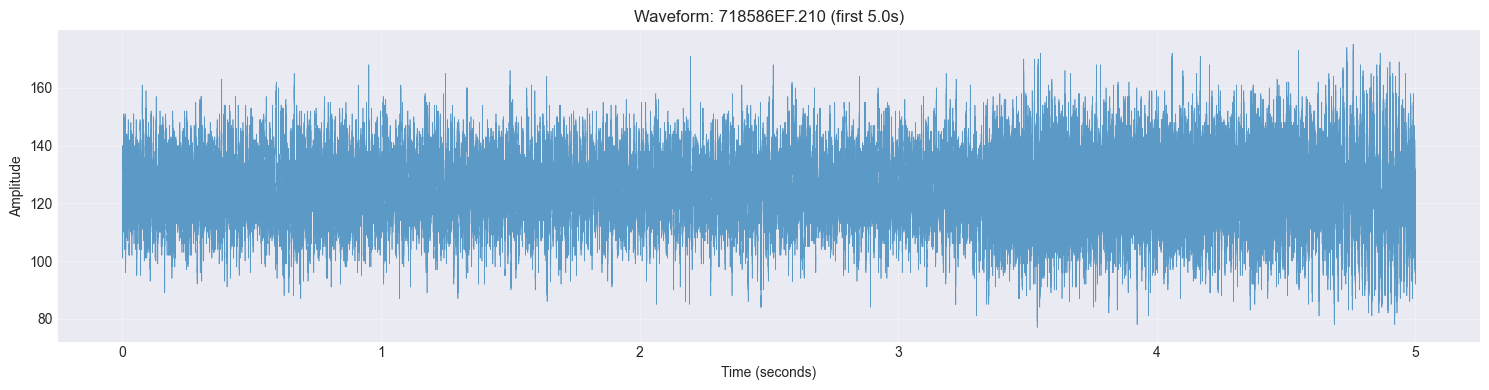

RMS Amplitude: 125.8


In [3]:
# Plot waveform of first few seconds
plot_duration = min(5.0, duration)  # Plot first 5 seconds or less
plot_samples = int(plot_duration * sample_rate)
time_axis = np.arange(plot_samples) / sample_rate

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(time_axis, data[:plot_samples], linewidth=0.5, alpha=0.7)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude')
ax.set_title(f'Waveform: {test_file.name} (first {plot_duration:.1f}s)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"RMS Amplitude: {np.sqrt(np.mean(data[:plot_samples]**2)):.1f}")

### Initial Visualization: Full-Range Spectrogram

Let's examine the frequency content across the entire recordable range (0-96 kHz).

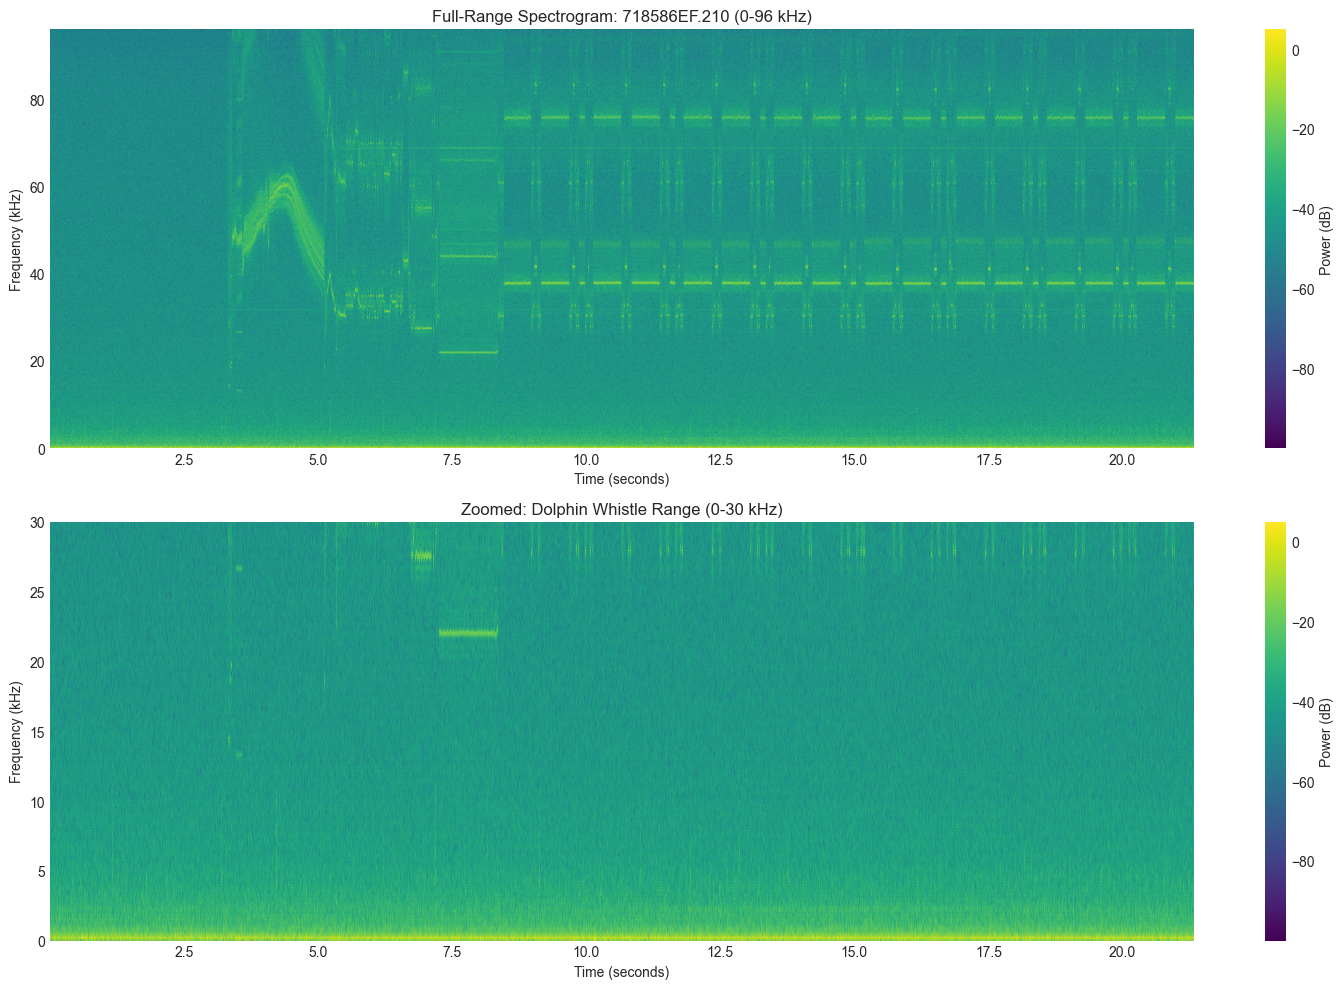

Spectrogram computed: 7999 time bins × 513 frequency bins
Time resolution: 0.0027 seconds
Frequency resolution: 187.5 Hz


In [4]:
# Compute spectrogram - balanced parameters for overview
nperseg = 1024  # Balanced time-frequency resolution
noverlap = 512  # 50% overlap

f, t, Sxx = signal.spectrogram(
    data,
    fs=sample_rate,
    nperseg=nperseg,
    noverlap=noverlap,
    window='hamming'
)

# Convert to dB scale
Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Add small constant to avoid log(0)

# Plot full-range spectrogram
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Full range (0-96 kHz)
im1 = ax1.pcolormesh(t, f/1000, Sxx_dB, shading='gouraud', cmap='viridis')
ax1.set_ylabel('Frequency (kHz)')
ax1.set_xlabel('Time (seconds)')
ax1.set_title(f'Full-Range Spectrogram: {test_file.name} (0-96 kHz)')
ax1.set_ylim([0, 96])
plt.colorbar(im1, ax=ax1, label='Power (dB)')

# Zoomed to dolphin whistle range (0-30 kHz)
im2 = ax2.pcolormesh(t, f/1000, Sxx_dB, shading='gouraud', cmap='viridis')
ax2.set_ylabel('Frequency (kHz)')
ax2.set_xlabel('Time (seconds)')
ax2.set_title('Zoomed: Dolphin Whistle Range (0-30 kHz)')
ax2.set_ylim([0, 30])
plt.colorbar(im2, ax=ax2, label='Power (dB)')

plt.tight_layout()
plt.show()

print(f"Spectrogram computed: {len(t)} time bins × {len(f)} frequency bins")
print(f"Time resolution: {t[1]-t[0]:.4f} seconds")
print(f"Frequency resolution: {f[1]-f[0]:.1f} Hz")

---

## 2. Signal Detection

This section implements algorithms to automatically detect dolphin vocalizations in the recordings.

### 2.1 Click Detection

Dolphins produce high-frequency clicks for echolocation. We'll detect these using:
1. High-pass filtering (>20 kHz) to isolate click energy
2. Energy-based detection using Teager-Kaiser operator
3. Peak finding to identify individual clicks
4. Inter-click interval (ICI) analysis

In [7]:
# First, let's test on a smaller chunk to ensure the algorithm works
test_duration = 2.0  # seconds
test_samples = int(test_duration * sample_rate)
test_data = data[:test_samples]

print(f"Testing on {test_duration}s chunk ({test_samples:,} samples)...")
print(f"This is {(test_samples/len(data)*100):.1f}% of the full recording")

Testing on 2.0s chunk (384,000 samples)...
This is 9.4% of the full recording


In [8]:
def detect_clicks(data, fs, highpass_freq=20000, threshold_factor=4.0, 
                  min_separation=0.0001):
    """
    Detect dolphin clicks using high-pass filtering and energy detection.
    
    Parameters
    ----------
    data : array
        Audio signal
    fs : int
        Sampling rate (Hz)
    highpass_freq : float
        High-pass filter cutoff frequency (Hz)
    threshold_factor : float
        Detection threshold as multiple of noise floor
    min_separation : float
        Minimum time between clicks (seconds)
        
    Returns
    -------
    click_times : array
        Time of each detected click (seconds)
    click_indices : array
        Sample indices of detected clicks
    click_amplitudes : array
        Amplitude of each detected click
    """
    # High-pass filter to isolate click energy (>20 kHz)
    nyq = fs / 2
    fc = highpass_freq / nyq
    b, a = butter(4, fc, 'high')
    filtered = filtfilt(b, a, data)
    
    # Compute energy using Teager-Kaiser operator
    # TK energy: E[n] = x[n]^2 - x[n-1]*x[n+1]
    tk_energy = np.zeros(len(filtered))
    tk_energy[1:-1] = filtered[1:-1]**2 - filtered[:-2] * filtered[2:]
    tk_energy = np.abs(tk_energy)
    
    # Smooth the energy signal
    window_size = int(0.001 * fs)  # 1ms smoothing window
    kernel = np.ones(window_size) / window_size
    smoothed_energy = np.convolve(tk_energy, kernel, mode='same')
    
    # Adaptive threshold based on noise floor
    # Use median absolute deviation for robustness
    noise_floor = np.median(smoothed_energy)
    mad = np.median(np.abs(smoothed_energy - noise_floor))
    threshold = noise_floor + threshold_factor * mad
    
    # Find peaks above threshold
    min_samples = int(min_separation * fs)
    click_indices, properties = find_peaks(
        smoothed_energy,
        height=threshold,
        distance=min_samples
    )
    
    # Get click times and amplitudes
    click_times = click_indices / fs
    click_amplitudes = properties['peak_heights']
    
    return click_times, click_indices, click_amplitudes


# Process in chunks to avoid timeouts - start with 5 seconds
chunk_duration = 5.0  # seconds
chunk_samples = int(chunk_duration * sample_rate)
data_chunk = data[:chunk_samples]

print(f"🔍 Running click detection on {chunk_duration}s chunk...")
print(f"   Processing {chunk_samples:,} samples ({chunk_samples/len(data)*100:.1f}% of recording)")

import time
start_time = time.time()

click_times, click_indices, click_amps = detect_clicks(data_chunk, sample_rate)

elapsed = time.time() - start_time
print(f"   ⏱️  Processing time: {elapsed:.2f}s")

if len(click_times) > 0:
    print(f"\n✓ Detected {len(click_times)} potential clicks")
    print(f"  Time range: {click_times[0]:.3f}s to {click_times[-1]:.3f}s")
    print(f"  Mean amplitude: {np.mean(click_amps):.2f}")
    print(f"  Amplitude range: [{np.min(click_amps):.2f}, {np.max(click_amps):.2f}]")
    
    # Calculate inter-click intervals (ICI)
    if len(click_times) > 1:
        ici = np.diff(click_times) * 1000  # Convert to milliseconds
        print(f"\n📊 Inter-Click Intervals (ICI):")
        print(f"  Mean ICI: {np.mean(ici):.2f} ms")
        print(f"  Median ICI: {np.median(ici):.2f} ms")
        print(f"  Std ICI: {np.std(ici):.2f} ms")
        print(f"  ICI range: [{np.min(ici):.2f}, {np.max(ici):.2f}] ms")
else:
    print("\n⚠️  No clicks detected in this chunk")
    print("   This could mean: no dolphins present, or parameters need tuning")

🔍 Running click detection on 5.0s chunk...
   Processing 960,000 samples (23.4% of recording)
   ⏱️  Processing time: 0.07s

✓ Detected 11953 potential clicks
  Time range: 3.290s to 4.999s
  Mean amplitude: 61.59
  Amplitude range: [8.09, 77.05]

📊 Inter-Click Intervals (ICI):
  Mean ICI: 0.14 ms
  Median ICI: 0.13 ms
  Std ICI: 0.26 ms
  ICI range: [0.10, 28.02] ms


In [9]:
import contextlib
from itertools import islice

class RuntimeGuard:
    """Simple runtime watchdog for long-running loops.

    Call ``check()`` periodically inside loops to raise ``TimeoutError`` if the
    configured time budget is exceeded. Keep budgets small (<60s) to avoid
    runaway notebook executions.
    """

    def __init__(self, label: str = "operation", max_seconds: float = 15.0):
        self.label = label
        self.max_seconds = max_seconds
        self._start = time.perf_counter()

    def check(self) -> None:
        elapsed = time.perf_counter() - self._start
        if elapsed > self.max_seconds:
            raise TimeoutError(
                f"{self.label} exceeded {self.max_seconds:.1f}s (elapsed {elapsed:.1f}s)."
            )


@contextlib.contextmanager
def timed_block(label: str, max_seconds: float = 15.0, logger=print):
    """Context manager that logs duration and warns when exceeding time budget."""
    start = time.perf_counter()
    try:
        yield
    finally:
        elapsed = time.perf_counter() - start
        if elapsed > max_seconds:
            logger(
                f"⚠️  {label} took {elapsed:.2f}s (> {max_seconds:.1f}s). "
                "Consider reducing chunk size or adjusting parameters."
            )
        else:
            logger(f"⏱️  {label} completed in {elapsed:.2f}s")


def iterate_chunks(signal_array, fs, chunk_duration=5.0, overlap=0.5, max_duration=5.0):
    """Yield overlapping chunks while enforcing an absolute chunk-duration cap."""
    if chunk_duration > max_duration:
        raise ValueError(
            f"chunk_duration={chunk_duration} exceeds max_duration={max_duration}. "
            "Reduce the requested chunk size to stay within runtime guardrails."
        )

    chunk_samples = int(chunk_duration * fs)
    overlap = float(overlap)
    if not (0.0 <= overlap < 1.0):
        raise ValueError("overlap must be in [0.0, 1.0).")

    step = max(int(chunk_samples * (1 - overlap)), 1)
    guard = RuntimeGuard(label="chunk iteration", max_seconds=30.0)

    for start in range(0, len(signal_array), step):
        guard.check()
        end = min(start + chunk_samples, len(signal_array))
        yield start, end, signal_array[start:end]
        if end >= len(signal_array):
            break


#### Runtime Guardrails

To keep the notebook responsive, use the `RuntimeGuard`, `timed_block`, and `iterate_chunks` helpers above. They cap chunk durations, emit warnings when steps exceed 15–30 seconds, and can abort loops via `TimeoutError`. Always start with ≤5 s chunks and only scale after visually confirming the results.

#### Chunk-Level Comparison: Buoy Sample vs Special Files
We’ll benchmark click detections on a random subset of standard buoy recordings against the two new `data/special` files, using the same 5-second chunk to keep runtimes bounded.

In [12]:
rng = np.random.default_rng(42)

buoy_dir = Path('../data/Buoy210_100300_100399')
special_dir = Path('../data/special')

all_buoy_files = sorted(buoy_dir.glob('*.210'))
special_files = sorted(f for f in special_dir.iterdir() if f.is_file())

print(f"Found {len(all_buoy_files)} buoy files and {len(special_files)} special files")

if len(all_buoy_files) < 10:
    raise RuntimeError("Need at least 10 buoy files for the comparison sample")
if len(special_files) == 0:
    raise RuntimeError("No files detected in data/special")

selected_buoy_indices = rng.choice(len(all_buoy_files), size=10, replace=False)
selected_buoy_files = [all_buoy_files[i] for i in sorted(selected_buoy_indices)]

print("\nSampled buoy files:")
for path in selected_buoy_files:
    print(f"  - {path.name}")

print("\nSpecial files:")
for path in special_files:
    print(f"  - {path.name}")

comparison_records = []
chunk_duration = 5.0
chunk_samples = int(chunk_duration * sample_rate)

for source_label, file_list in (("buoy", selected_buoy_files), ("special", special_files)):
    for file_path in file_list:
        with timed_block(f"Processing {file_path.name}", max_seconds=15.0):
            file_data = read_ears_file(file_path)
            signal_data = file_data['data'][:chunk_samples]
            fs = file_data['fs']
            if len(signal_data) == 0:
                print(f"⚠️ {file_path.name} has no data; skipping")
                continue

            click_times_local, click_indices_local, click_amps_local = detect_clicks(
                signal_data,
                fs,
                threshold_factor=4.0,
            )

            record = {
                "file_name": file_path.name,
                "source": source_label,
                "click_count": len(click_times_local),
                "click_rate_per_s": len(click_times_local) / chunk_duration,
                "mean_amp": float(np.mean(click_amps_local)) if len(click_amps_local) else np.nan,
                "median_amp": float(np.median(click_amps_local)) if len(click_amps_local) else np.nan,
                "max_amp": float(np.max(click_amps_local)) if len(click_amps_local) else np.nan,
            }

            if len(click_times_local) > 1:
                ici_ms_local = np.diff(click_times_local) * 1000.0
                record.update(
                    {
                        "median_ici_ms": float(np.median(ici_ms_local)),
                        "min_ici_ms": float(np.min(ici_ms_local)),
                        "max_ici_ms": float(np.max(ici_ms_local)),
                    }
                )
            else:
                record.update(
                    {
                        "median_ici_ms": np.nan,
                        "min_ici_ms": np.nan,
                        "max_ici_ms": np.nan,
                    }
                )

            comparison_records.append(record)

comparison_df = pd.DataFrame(comparison_records)
comparison_df.sort_values(['source', 'file_name'], inplace=True)

print("\nSummary of comparisons (first 5 rows):")
display(comparison_df.head())

summary_stats = comparison_df.groupby('source').agg(
    click_count_mean=('click_count', 'mean'),
    click_rate_mean=('click_rate_per_s', 'mean'),
    median_amp_mean=('median_amp', 'mean'),
    median_ici_median=('median_ici_ms', 'median'),
    sample_size=('file_name', 'count'),
)

print("\nGroup-level aggregates:")
display(summary_stats)

reports_dir = Path('reports')
reports_dir.mkdir(exist_ok=True)
comparison_path = reports_dir / 'click_comparison_buoy_vs_special.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"\n💾 Saved detailed comparison to {comparison_path}")

Found 100 buoy files and 2 special files

Sampled buoy files:
  - 7185877F.210
  - 71858791.210
  - 718587E1.210
  - 718587F7.210
  - 7185880A.210
  - 71858813.210
  - 71858816.210
  - 71858822.210
  - 7185882E.210
  - 71858830.210

Special files:
  - 71621DC7 (1).190
  - 7164403B.130
⏱️  Processing 7185877F.210 completed in 0.22s
⏱️  Processing 71858791.210 completed in 0.22s
⏱️  Processing 718587E1.210 completed in 0.21s
⏱️  Processing 718587F7.210 completed in 0.21s
⏱️  Processing 7185880A.210 completed in 0.21s
⏱️  Processing 71858813.210 completed in 0.21s
⏱️  Processing 71858816.210 completed in 0.21s
⏱️  Processing 71858822.210 completed in 0.21s
⏱️  Processing 7185882E.210 completed in 0.21s
⏱️  Processing 71858830.210 completed in 0.21s
⏱️  Processing 71621DC7 (1).190 completed in 0.21s
⏱️  Processing 7164403B.130 completed in 0.21s

Summary of comparisons (first 5 rows):


file_name source  click_count  click_rate_per_s   mean_amp  median_amp  \
0  7185877F.210   buoy        12512            2502.4  59.715720   63.434482   
1  71858791.210   buoy         4285             857.0  26.335716   11.210072   
2  718587E1.210   buoy         1132             226.4   8.092091    6.630981   
3  718587F7.210   buoy          891             178.2   6.939406    6.331746   
4  7185880A.210   buoy          532             106.4   6.202498    6.088638   

      max_amp  median_ici_ms  min_ici_ms  max_ici_ms  
0   82.365292       0.130208    0.098958  150.437500  
1  241.102951       0.135417    0.098958   36.739583  
2   25.706252       0.145833    0.098958  102.401042  
3   15.585653       0.151042    0.098958  168.687500  
4    7.723576       0.182292    0.098958  128.609375


Group-level aggregates:


click_count_mean  click_rate_mean  median_amp_mean  \
source                                                        
buoy               2325.6           465.12        18.484337   
special             446.0            89.20         8.542055   

         median_ici_median  sample_size  
source                                   
buoy              0.148438           10  
special           0.218750            2


💾 Saved detailed comparison to reports/click_comparison_buoy_vs_special.csv


#### Threshold Sensitivity (4 vs 6 vs 8)
We’ll re-run the 5 s chunk detector across thresholds 4, 6, and 8 for the same 10 buoy files and 2 special files to see how counts fall off—helpful for spotting likely false positives (large drops) or possible false negatives (detections disappearing entirely).

⏱️  Threshold 4.0 | 7185877F.210 completed in 0.21s
⏱️  Threshold 4.0 | 71858791.210 completed in 0.21s
⏱️  Threshold 4.0 | 718587E1.210 completed in 0.21s
⏱️  Threshold 4.0 | 718587F7.210 completed in 0.21s
⏱️  Threshold 4.0 | 7185880A.210 completed in 0.21s
⏱️  Threshold 4.0 | 71858813.210 completed in 0.21s
⏱️  Threshold 4.0 | 71858816.210 completed in 0.21s
⏱️  Threshold 4.0 | 71858822.210 completed in 0.21s
⏱️  Threshold 4.0 | 7185882E.210 completed in 0.23s
⏱️  Threshold 4.0 | 71858830.210 completed in 0.21s
⏱️  Threshold 4.0 | 71621DC7 (1).190 completed in 0.21s
⏱️  Threshold 4.0 | 7164403B.130 completed in 0.23s
⏱️  Threshold 6.0 | 7185877F.210 completed in 0.21s
⏱️  Threshold 6.0 | 71858791.210 completed in 0.21s
⏱️  Threshold 6.0 | 718587E1.210 completed in 0.21s
⏱️  Threshold 6.0 | 718587F7.210 completed in 0.21s
⏱️  Threshold 6.0 | 7185880A.210 completed in 0.21s
⏱️  Threshold 6.0 | 71858813.210 completed in 0.21s
⏱️  Threshold 6.0 | 71858816.210 completed in 0.21s
⏱️  Thre

file_name source  threshold  click_count  click_rate_per_s  median_amp  \
0   7185877F.210   buoy        4.0        12512            2502.4   63.434482   
12  7185877F.210   buoy        6.0        12170            2434.0   63.600341   
24  7185877F.210   buoy        8.0        12044            2408.8   63.671498   
1   71858791.210   buoy        4.0         4285             857.0   11.210072   
13  71858791.210   buoy        6.0         3140             628.0   15.112821   
25  71858791.210   buoy        8.0         2559             511.8   19.343060   
2   718587E1.210   buoy        4.0         1132             226.4    6.630981   
14  718587E1.210   buoy        6.0          518             103.6    9.020356   
26  718587E1.210   buoy        8.0          396              79.2   10.246853   
3   718587F7.210   buoy        4.0          891             178.2    6.331746   
15  718587F7.210   buoy        6.0          295              59.0    7.615141   
27  718587F7.210   buoy        8.0          158              31.6    9.027318   

       max_amp  median_ici_ms  min_ici_ms  max_ici_ms  
0    82.365292       0.130208    0.098958  150.437500  
12   82.365292       0.130208    0.098958  248.187500  
24   82.365292       0.130208    0.098958  505.114583  
1   241.102951       0.135417    0.098958   36.739583  
13  241.102951       0.135417    0.098958   40.552083  
25  241.102951       0.135417    0.098958   52.708333  
2    25.706252       0.145833    0.098958  102.401042  
14   25.706252       0.135417    0.098958  753.656250  
26   25.706252       0.130208    0.098958  910.687500  
3    15.585653       0.151042    0.098958  168.687500  
15   15.585653       0.145833    0.098958  594.786458  
27   15.585653       0.145833    0.098958  595.333333


Grouped threshold summary:


click_rate_mean  click_rate_median  retention_pct_median  \
source  threshold                                                             
buoy    4.0                 465.12              195.2            100.000000   
        6.0                 351.28               68.0             37.456131   
        8.0                 320.54               40.0             22.473654   
special 4.0                  89.20               89.2            100.000000   
        6.0                   3.90                3.9              4.392001   
        8.0                   0.80                0.8              0.917431   

                   median_amp_mean  sample_size  
source  threshold                                
buoy    4.0              18.484337           10  
        6.0              20.553682           10  
        8.0              16.045966           10  
special 4.0               8.542055            2  
        6.0               9.734582            2  
        8.0              31.695353            2


💾 Saved detailed sweep to reports/click_threshold_sweep_details.csv
💾 Saved summary to reports/click_threshold_sweep_summary.csv


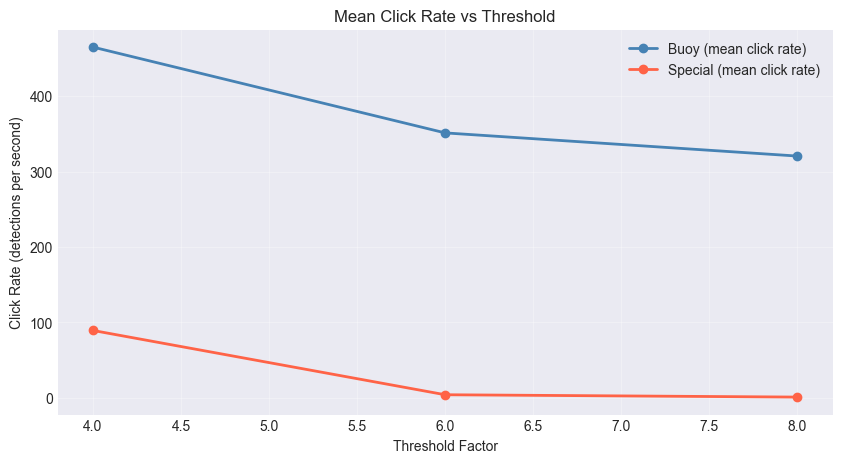

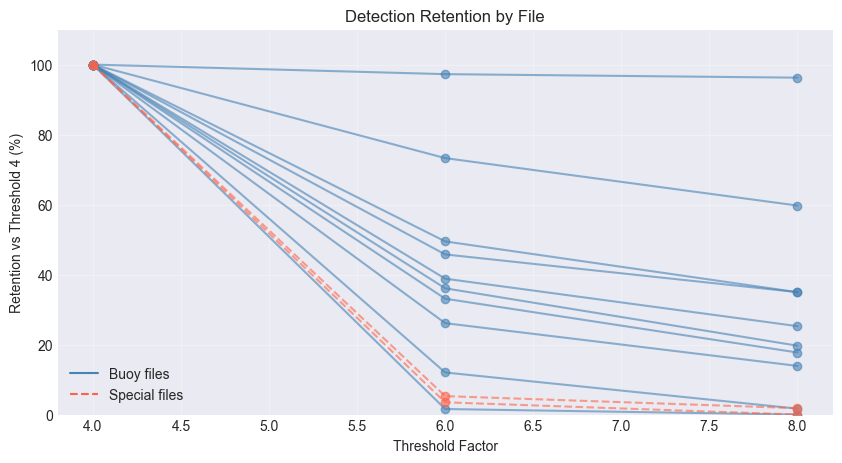

In [13]:
threshold_values = [4.0, 6.0, 8.0]
chunk_duration = 5.0
threshold_records = []

if 'selected_buoy_files' not in globals() or 'special_files' not in globals():
    raise RuntimeError("Run the comparison cell above to define selected_buoy_files and special_files first.")

for threshold_factor in threshold_values:
    for source_label, file_list in (("buoy", selected_buoy_files), ("special", special_files)):
        for file_path in file_list:
            with timed_block(f"Threshold {threshold_factor} | {file_path.name}", max_seconds=15.0):
                file_data = read_ears_file(file_path)
                fs = file_data['fs']
                chunk_samples = int(chunk_duration * fs)
                signal_data = file_data['data'][:chunk_samples]
                if len(signal_data) == 0:
                    print(f"⚠️ {file_path.name} has no data; skipping")
                    continue

                click_times_local, click_indices_local, click_amps_local = detect_clicks(
                    signal_data,
                    fs,
                    threshold_factor=threshold_factor,
                )

                record = {
                    "file_name": file_path.name,
                    "source": source_label,
                    "threshold": threshold_factor,
                    "click_count": len(click_times_local),
                    "click_rate_per_s": len(click_times_local) / chunk_duration,
                    "median_amp": float(np.median(click_amps_local)) if len(click_amps_local) else np.nan,
                    "max_amp": float(np.max(click_amps_local)) if len(click_amps_local) else np.nan,
                }

                if len(click_times_local) > 1:
                    ici_ms_local = np.diff(click_times_local) * 1000.0
                    record.update(
                        {
                            "median_ici_ms": float(np.median(ici_ms_local)),
                            "min_ici_ms": float(np.min(ici_ms_local)),
                            "max_ici_ms": float(np.max(ici_ms_local)),
                        }
                    )
                else:
                    record.update(
                        {
                            "median_ici_ms": np.nan,
                            "min_ici_ms": np.nan,
                            "max_ici_ms": np.nan,
                        }
                    )

                threshold_records.append(record)

threshold_df = pd.DataFrame(threshold_records)
threshold_df.sort_values(['source', 'file_name', 'threshold'], inplace=True)

print("Threshold sweep preview:")
display(threshold_df.head(12))

baseline_counts = threshold_df[threshold_df['threshold'] == threshold_values[0]][
    ['file_name', 'click_count']
].rename(columns={'click_count': 'click_count_baseline'})

threshold_df = threshold_df.merge(baseline_counts, on='file_name', how='left')
threshold_df['retention_pct'] = np.where(
    threshold_df['click_count_baseline'] > 0,
    100.0 * threshold_df['click_count'] / threshold_df['click_count_baseline'],
    np.nan,
)

summary = threshold_df.groupby(['source', 'threshold']).agg(
    click_rate_mean=('click_rate_per_s', 'mean'),
    click_rate_median=('click_rate_per_s', 'median'),
    retention_pct_median=('retention_pct', 'median'),
    median_amp_mean=('median_amp', 'mean'),
    sample_size=('file_name', 'nunique'),
)

print("\nGrouped threshold summary:")
display(summary)

reports_dir = Path('reports')
reports_dir.mkdir(exist_ok=True)
threshold_detail_path = reports_dir / 'click_threshold_sweep_details.csv'
threshold_summary_path = reports_dir / 'click_threshold_sweep_summary.csv'
threshold_df.to_csv(threshold_detail_path, index=False)
summary.to_csv(threshold_summary_path)

print(f"\n💾 Saved detailed sweep to {threshold_detail_path}")
print(f"💾 Saved summary to {threshold_summary_path}")

# --- Visualization helpers ---
palette = {'buoy': 'steelblue', 'special': 'tomato'}

fig, ax = plt.subplots(figsize=(10, 5))
for source_label, group in summary.reset_index().groupby('source'):
    ax.plot(
        group['threshold'],
        group['click_rate_mean'],
        marker='o',
        linewidth=2,
        color=palette.get(source_label, 'gray'),
        label=f"{source_label.title()} (mean click rate)"
    )
ax.set_xlabel('Threshold Factor')
ax.set_ylabel('Click Rate (detections per second)')
ax.set_title('Mean Click Rate vs Threshold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
for source_label, group in threshold_df.groupby('source'):
    for file_name, file_group in group.groupby('file_name'):
        ax.plot(
            file_group['threshold'],
            file_group['retention_pct'],
            marker='o',
            linestyle='-' if source_label == 'buoy' else '--',
            linewidth=1.5,
            color=palette.get(source_label, 'gray'),
            alpha=0.6,
        )
    ax.plot([], [], color=palette[source_label], linestyle='-' if source_label == 'buoy' else '--', label=f"{source_label.title()} files")

ax.set_xlabel('Threshold Factor')
ax.set_ylabel('Retention vs Threshold 4 (%)')
ax.set_title('Detection Retention by File')
ax.set_ylim(0, 110)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

#### Click Sanity Check

Quick visual inspection of the first detected clicks helps us verify that the energy peaks correspond to plausible dolphin events before scaling up processing.

click_id    time_s    ici_ms  energy_amplitude
0         0  3.290026       NaN          8.095669
1         1  3.295526  5.500000         14.642734
2         2  3.295630  0.104167         16.496159
3         3  3.295755  0.125000         17.044897
4         4  3.295927  0.171875         18.332116
5         5  3.296036  0.109375         18.690015
6         6  3.296141  0.104167         18.682403
7         7  3.296302  0.161458         18.857399
8         8  3.296568  0.265625          9.411421
9         9  3.296708  0.140625          8.454939

💾 Saved top-10 click preview to reports/click_preview_top10.csv


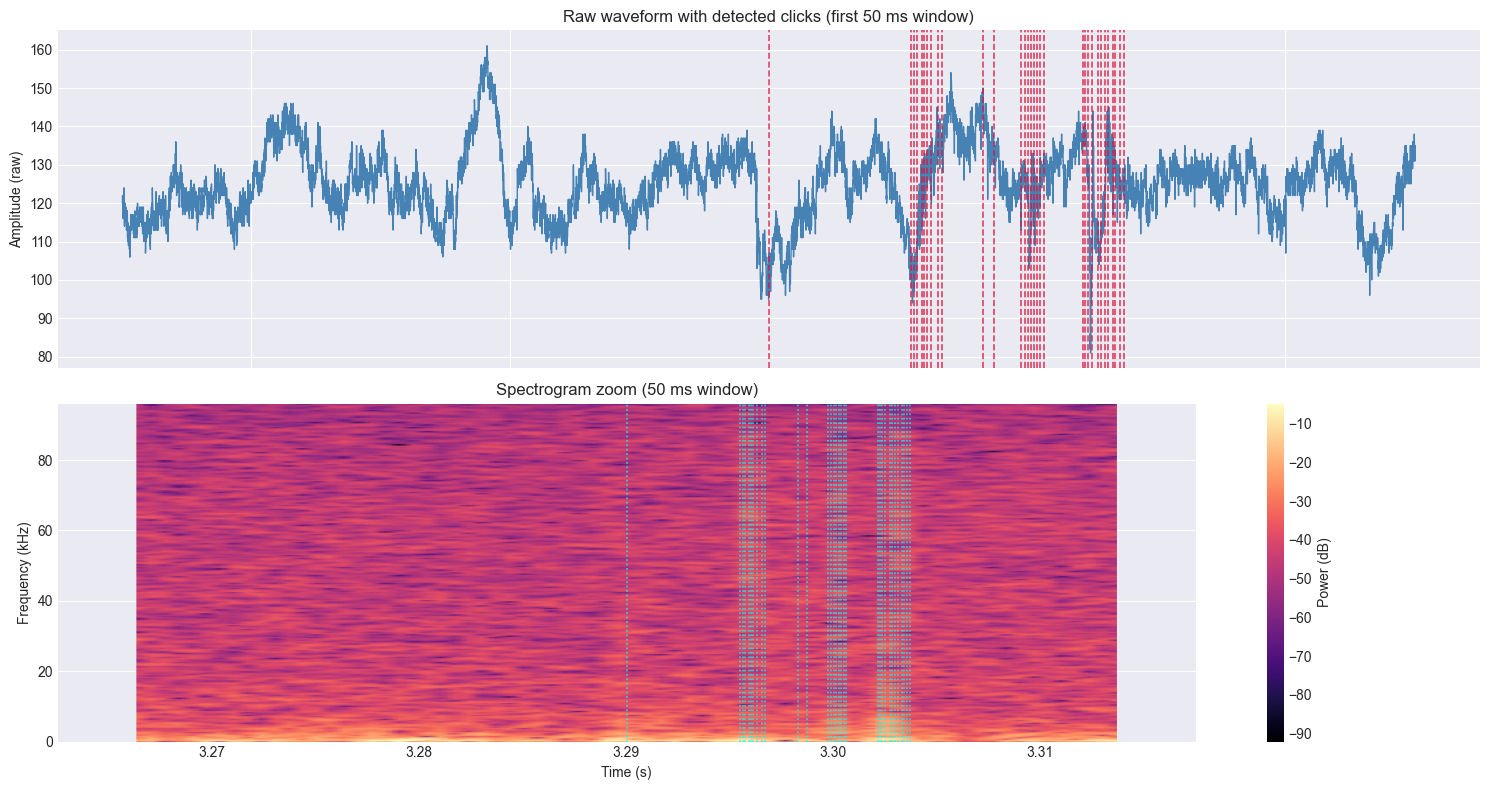

⏱️  Click sanity check (5 s chunk) completed in 0.25s


In [10]:
with timed_block("Click sanity check (5 s chunk)", max_seconds=10.0):
    if len(click_times) == 0:
        print("⚠️ No clicks detected in the current chunk — nothing to visualize yet.")
    else:
        ici_ms = np.empty_like(click_times)
        ici_ms[0] = np.nan
        if len(click_times) > 1:
            ici_ms[1:] = np.diff(click_times) * 1000.0
        
        click_preview_df = pd.DataFrame(
            {
                "click_id": np.arange(len(click_times)),
                "time_s": click_times,
                "ici_ms": ici_ms,
                "energy_amplitude": click_amps,
            }
        )
        
        top_preview = click_preview_df.head(10).copy()
        display(top_preview)
        
        Path("reports").mkdir(exist_ok=True)
        preview_path = Path("reports/click_preview_top10.csv")
        top_preview.to_csv(preview_path, index=False)
        print(f"💾 Saved top-10 click preview to {preview_path}")
        
        focus_window_s = 0.05  # 50 ms window around the first click
        first_click_time = click_times[0]
        window_start = max(first_click_time - focus_window_s / 2, 0.0)
        window_end = window_start + focus_window_s
        
        start_idx = int(window_start * sample_rate)
        end_idx = int(window_end * sample_rate)
        segment = data_chunk[start_idx:end_idx]
        time_axis_segment = np.arange(start_idx, end_idx) / sample_rate
        
        fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
        
        axes[0].plot(time_axis_segment, segment, color="steelblue", linewidth=1)
        in_window = (click_times >= window_start) & (click_times <= window_end)
        for ct in click_times[in_window]:
            axes[0].axvline(ct, color="crimson", linestyle="--", linewidth=1.2, alpha=0.8)
        axes[0].set_ylabel("Amplitude (raw)")
        axes[0].set_title("Raw waveform with detected clicks (first 50 ms window)")
        
        nperseg_zoom = 512
        noverlap_zoom = 384
        f_zoom, t_zoom, Sxx_zoom = signal.spectrogram(
            segment,
            fs=sample_rate,
            nperseg=nperseg_zoom,
            noverlap=noverlap_zoom,
            window="hann",
        )
        Sxx_zoom_db = 10 * np.log10(Sxx_zoom + 1e-12)
        
        pcm = axes[1].pcolormesh(
            window_start + t_zoom,
            f_zoom / 1000.0,
            Sxx_zoom_db,
            shading="gouraud",
            cmap="magma",
        )
        axes[1].set_ylabel("Frequency (kHz)")
        axes[1].set_xlabel("Time (s)")
        axes[1].set_ylim(0, nyquist / 1000.0)
        axes[1].set_title("Spectrogram zoom (50 ms window)")
        for ct in click_times[in_window]:
            axes[1].axvline(ct, color="cyan", linestyle=":", linewidth=1.2, alpha=0.8)
        fig.colorbar(pcm, ax=axes[1], label="Power (dB)")
        
        plt.tight_layout()
        plt.show()

#### Visualize Detected Clicks

Let's visualize the detected clicks overlaid on the spectrogram in the high-frequency range.

Computing spectrogram for visualization...


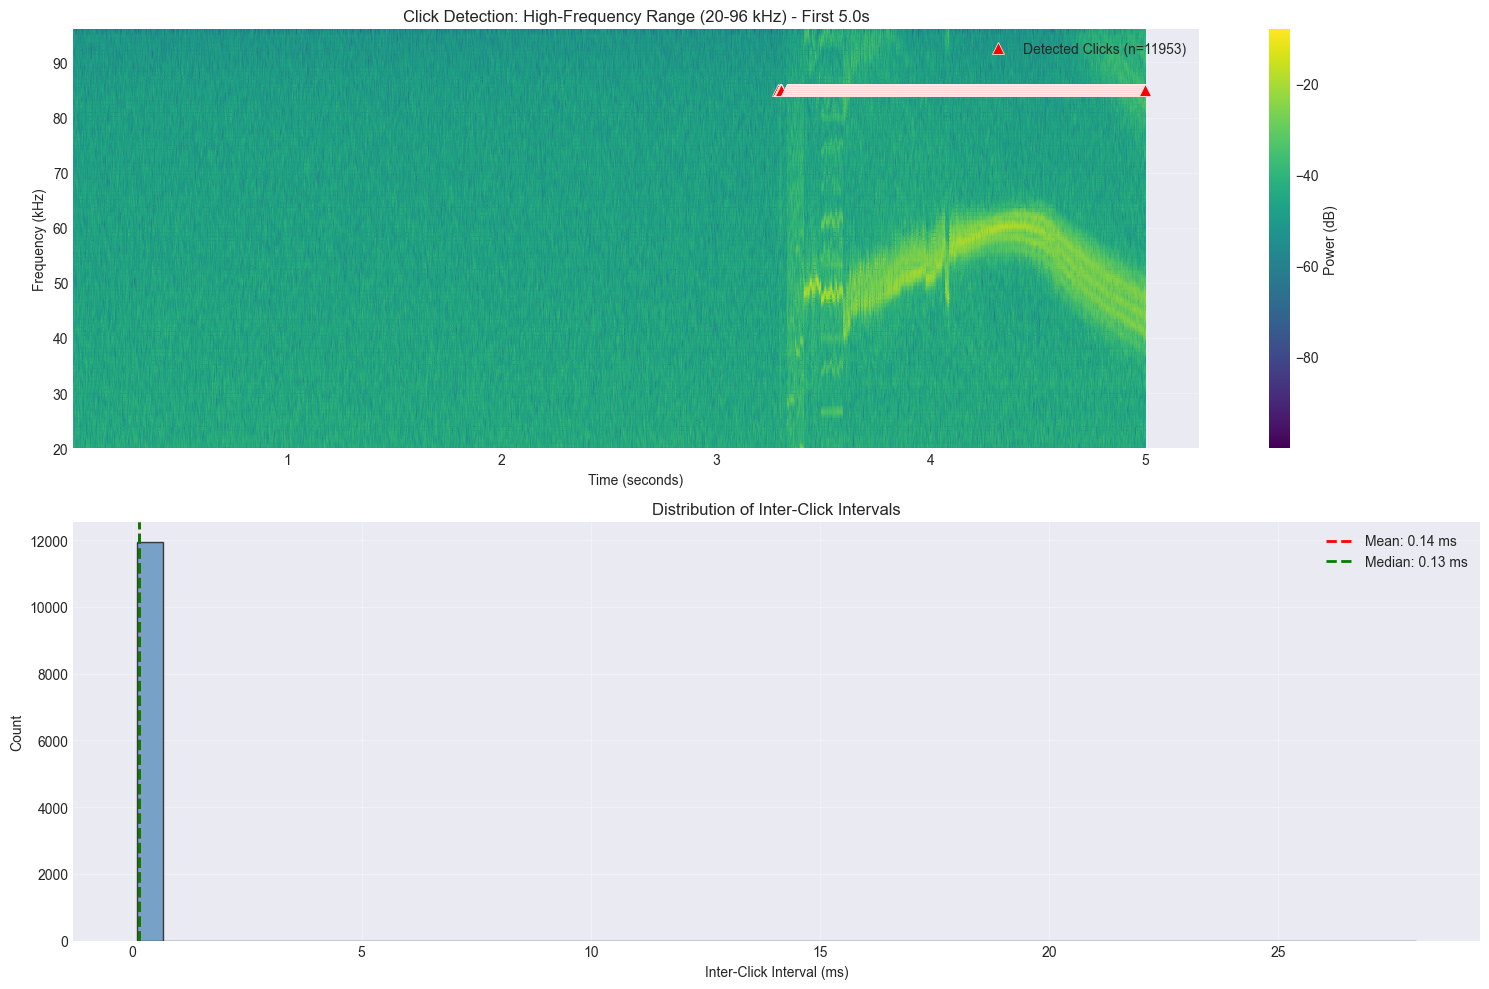

✓ Click visualization complete


In [6]:
# Create spectrogram focused on click range (20-96 kHz) for the chunk
# Use shorter window for better time resolution
nperseg_clicks = 256
noverlap_clicks = 128

print(f"Computing spectrogram for visualization...")
f_click, t_click, Sxx_click = signal.spectrogram(
    data_chunk,
    fs=sample_rate,
    nperseg=nperseg_clicks,
    noverlap=noverlap_clicks,
    window='hamming'
)

Sxx_click_dB = 10 * np.log10(Sxx_click + 1e-10)

# Plot spectrogram with click detections
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: High-frequency spectrogram with clicks
im1 = axes[0].pcolormesh(t_click, f_click/1000, Sxx_click_dB, 
                         shading='gouraud', cmap='viridis')
if len(click_times) > 0:
    axes[0].plot(click_times, np.ones_like(click_times) * 85, 'r^', 
                 markersize=8, label=f'Detected Clicks (n={len(click_times)})', 
                 markeredgecolor='white', markeredgewidth=0.5)
axes[0].set_ylabel('Frequency (kHz)')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_title(f'Click Detection: High-Frequency Range (20-96 kHz) - First {chunk_duration}s')
axes[0].set_ylim([20, 96])
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[0], label='Power (dB)')

# Plot 2: Inter-click intervals histogram
if len(click_times) > 1:
    axes[1].hist(ici, bins=min(50, len(ici)), edgecolor='black', alpha=0.7, color='steelblue')
    axes[1].axvline(np.mean(ici), color='r', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(ici):.2f} ms')
    axes[1].axvline(np.median(ici), color='g', linestyle='--', 
                    linewidth=2, label=f'Median: {np.median(ici):.2f} ms')
    axes[1].set_xlabel('Inter-Click Interval (ms)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Inter-Click Intervals')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
elif len(click_times) == 1:
    axes[1].text(0.5, 0.5, 'Only 1 click detected - no ICI to analyze', 
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
else:
    axes[1].text(0.5, 0.5, 'No clicks detected - try adjusting threshold_factor', 
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.show()

print(f"✓ Click visualization complete")

### 2.2 Whistle Detection

Dolphin whistles are frequency-modulated signals in the 2-20 kHz range. Detection approach:
1. Band-pass filtering (2-20 kHz)
2. High-resolution spectrogram computation
3. Ridge detection / contour following
4. Duration filtering (minimum 0.1 seconds)

In [ ]:
# TO BE IMPLEMENTED IN PHASE 2.2
print("🔨 Whistle detection algorithm - Coming in Phase 2.2")

---

## 3. Feature Extraction

*Coming in Phase 3*

---

## 4. Classification Algorithms

*Coming in Phase 4*

---

## 5. Batch Analysis

*Coming in Phase 6*

---

## 6. Visualization Suite

*Coming in Phase 5*

---

## 7. Language Analysis & Interpretation

*Coming in Phase 7*

---

## Summary & Next Steps

This notebook provides a comprehensive framework for analyzing dolphin communication in EARS underwater acoustic recordings. The analysis pipeline includes:

✅ Data loading and initial visualization  
🔨 Detection algorithms (in progress)  
⏳ Feature extraction (planned)  
⏳ Classification and analysis (planned)  
⏳ Batch processing framework (planned)  

### Future Enhancements

- Higher sampling rate recordings (>400 kHz) to capture full click spectrum
- Stereophonic/array recordings for directionality and ranging
- Machine learning models for automated classification
- Real-time processing capabilities
- Integration with behavioral observation data

---

**Notebook Version:** 0.1.0  
**Last Updated:** October 9, 2025  
**Status:** Phase 1 Complete - Ready for detection algorithm implementation